<a href="https://colab.research.google.com/github/avinashmane/colab/blob/master/strava_likers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code/Parameters
## Setup

## Todo
* replace path for cfg_strava and auth

In [1]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    DIR='/m/colab'
else:
    DIR='/content/drive/MyDrive/m/lib'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
if os.name!='nt':
    !pip install nerodia
    if True:
      !apt-get update # to update ubuntu to correctly run apt install
      if False:
        !apt install firefox-geckodriver
        !cp /usr/bin/geckodriver {DIR}
        !cp -r /usr/lib/firefox/ {DIR}
      if True:
        !apt install chromium-chromedriver
        !cp /usr/lib/chromium-browser/chromedriver {DIR}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.n

## Code

In [14]:
import yaml
import time
from datetime import datetime
import os
from nerodia.browser import Browser
import re
import logging
from IPython.display import Image

"""
clip to get parent
import re
# feedlike=re.comp
display([(x.tag_name,x.id,x.class_name,x.text[:100]) for x in (c[0]._xpath_adjacent(  adjacent='ancestor', plural=True))])
# c[0]._xpath_adjacent( tag_name='div',class_name=re.compile('^feed'), adjacent='ancestor', plural=False)
"""

class SocialMediaSite:
    authType=None
    cfg={}

    giveKudosPattern=re.compile(r'.*ive kudos')    
    def __init__(self,b,browser='firefox',authFile='/content/drive/MyDrive/m/auth/auth.yaml'):
        # create brwoser unless provided
        self.browser=Browser(browser) if b==None else b
        
        with open(authFile) as file:
            # The FullLoader parameter handles the conversion from YAML
            # scalar values to Python the dictionary format
            auth = yaml.safe_load(file)
            self.auth={x:auth[x] for x in auth if x in ['strava','facebook']}
        
    def login():
      raise NotImplemented
      
    def loadCookie(self,cookieFile):
        if cookieFile and os.path.exists(cookieFile):
          self.browser.cookies.load(file=cookieFile)
          
    def saveCookie(self,cookieFile):
        return self.browser.cookies.save(file=cookieFile)
    def clearCookie(self,cookieFile):
        return self.browser.cookies.clear()
    def close(self):
        return self.browser.close()
    @staticmethod
    def getParent(el,tag,patClass):
      """
      Get parents with tag and patterm of class matching
      Parameters
      ----------
      - el : reference node
      - tag : tag_type (e.g. div)
      - patClass : class of patterns (re.compile)

      Returns
      -------
      - Single element than meets the requirements
      """
      return el._xpath_adjacent( tag_name='div',class_name=re.compile(patClass), adjacent='ancestor', plural=False)
    
    @staticmethod
    def _dumptag(el,tags,level=0):
      for c in el.children(tag_name=tags):
          print(' '*level,c.tag_name,c.id,c.text[:50])
          SocialMediaSite._dumptag(c,level+1)
    
        

class Strava(SocialMediaSite):
    authType='strava'
    def __init__(self,b=None,cookieFile=None,authFile='/content/drive/MyDrive/m/auth/auth.yaml',cfgFile='/content/drive/MyDrive/m/social-media/cfg_strava.yaml'):
        super().__init__(b,authFile=authFile)
        self.siteType='strava'
        
        with open(cfgFile) as file:
            cfg = yaml.safe_load(file)
            self.cfg.update(cfg['strava'])

    def login(self,login):
        auth=self.auth[self.authType][login]
        self.browser.goto('https://www.strava.com/login')

        try: # reject cookies
          rejButton=self.browser.button(value="Reject")
          if rejButton.exists:
            rejButton.click()
        except Exception as e:
            logging.warning( f"Error login1 {e!r}") #logging.warning 
      
        try:
          self.browser.text_field(id='email').value=auth['username']  #timeout did not work
          self.browser.text_field(id='password').value=auth['password']
          self.browser.button(id='login-button').click()
        except Exception as e:
          if 'dashboard' in self.browser.url:
            pass
          else:
            logging.warning( f"Error Login2 {e!r}") #logging.warning 
        
    def getClubs(self):
        self.browser.goto('https://www.strava.com/clubs/search')
        grps=[]
        # print(self.browser.ul(class_name="clubs").lis())
        for f in self.browser.ul(class_name="clubs").lis():
          # print(f.div().attribute_value("original-title"))
          for c in f.div().links():
            grps.append({"name":f.div().attribute_value("original-title"),
                         "link":c.attributes['href']})
        return (grps)
      
    def postInClub(self,club,title,text,imagePath):
        self.browser.goto(f'{club}/discussion')
        self.browser.link(id='new-post').click()
        self.browser.textarea(name='title').value=title
        self.browser.textarea(name='text').value=text
        # self.b.file_field(type='file').set='c:\\temp\\9955-2Certificate.png' #not working
        self.browser.file_field(type='file',index=0).value=imagePath #working
        self.browser.div(class_name="dropzone-previews").img().wait_until(method=lambda e: e.complete)
        time.sleep(3)
        self.browser.button(text='Publish').click()
        
    def getPostIds(self,club):
        self.browser.goto(f'{club}/discussion')
        return [{'id':x.parent().id,
          'title':   x.div(class_name='post-body').link().text,
          'link':    x.link(class_name='str-click-self-js').href,
          'userlink':x.link(class_name='str-click-name-js').href,
          'username':x.link(class_name='str-click-name-js').text,
          'time':    x.time().text,
          'kudos':   x.span(class_name="count-kudos").text,
          'comments':x.span(class_name="count-comments").text,
          } for x in self.browser.divs(class_name='topic')]
      
    def deletePost(self,id):
        "@id like post-19361836"
        self.browser.li(id=id).div(class_name='drop-down-menu').click()
        self.browser.li(id=id).button(text='Delete').click()
        self.browser.alert.ok()

    def deleteCurrentPost(self):
        "delete current post"
        self.browser.div(id="options-menu").click()
        self.browser.div(id="options-menu").link(text="Edit").click()

        self.browser.button(text='Delete').click()
        self.browser.alert.ok()
    def giveKudos(self):
      "Give Kudos in current screen"
      _=b.buttons(title=self.giveKudosPattern)
      for i,x in enumerate(_):
        try:
          card=strava.getParent(x,'div','^Card')
          logging.info(f"{i},{card.text.split(',')[:3]}")
          # x.click() 
          b.execute_script("arguments[0].click();", x)
        except Exception as e: 
          logging.warning(f"{i} error clicking {e!r}")
        time.sleep(.5)
      return 

    def scrolldown(self,pages):
      for i in range(pages):
        b.driver.execute_script("window.scrollTo(0,document.body.scrollHeight)")
        # b.send_keys(Keys.CONTROL  + Keys.END )     
        # b.driver.execute_script("window.scrollBy(0, document.body.scrollHeight);")
        time.sleep(1)
    def goto(self,url):
      return self.browser.goto(url)
    def image(self):
      b.execute_script("window.scrollTo(0,0)")
      return Image(b.screenshot.png())
    def close(self):
      self.browser.close()
        


# Process
## Create headless

In [15]:
" Test Selenium headless"
if True:
    if os.name=='nt':
        b=Browser('chrome',)
    else:
        
        # import sys
        # sys.path.insert(0,f'{DIR}/geckodriver')
        from selenium import webdriver

        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        # b =webdriver.Chrome('chromedriver',options=chrome_options)
        b=Browser('chrome',options=chrome_options,)
    # b.get("https://www.google.com")
    dir(b)

In [16]:
# %debug
if os.name=='nt':
  strava=Strava(b,authFile=r'c:\i\auth\auth.yaml',cfgFile="c:/m/social-media-automation/cfg_strava.yaml")
else:
  strava=Strava(b,authFile=r'/content/drive/MyDrive/m/auth/auth.yaml',cfgFile="/content/drive/MyDrive/m/social-media/cfg_strava.yaml")
# test case
# strava.login("avinash")

In [17]:
strava.login("avinash")

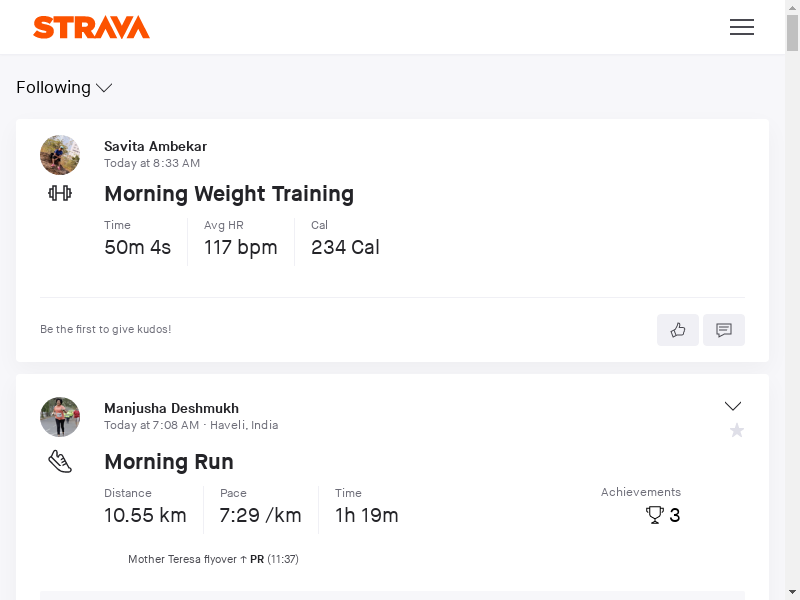

In [18]:
Image(b.screenshot.png())

## Give likes in feed

In [19]:
# b.goto('https://www.strava.com/clubs/196654/recent_activity')
strava.browser.title
strava.scrolldown(2)

In [20]:
display(len(b.divs(class_name=re.compile('^Card'))))

59

In [21]:
strava.giveKudos()

## Give likes on Club

In [22]:
# b.goto('https://www.strava.com/clubs/196654/recent_activity')

display(len(b.divs(class_name=re.compile('^Card'))))

59

In [23]:
for club in strava.cfg['avinash']['clubs']:
  strava.goto(f"{club}/recent_activity")
  print(f"===> {club}")
  time.sleep(1)
  strava.giveKudos()

===> https://www.strava.com/clubs/pcmcrunners
===> https://www.strava.com/clubs/pcmcbikers
===> https://www.strava.com/clubs/punecycling
===> https://www.strava.com/clubs/didyouruntoday
===> https://www.strava.com/clubs/PuneWalkers
===> https://www.strava.com/clubs/prettycoolmileagechallenge
===> https://www.strava.com/clubs/mileageleague


## test

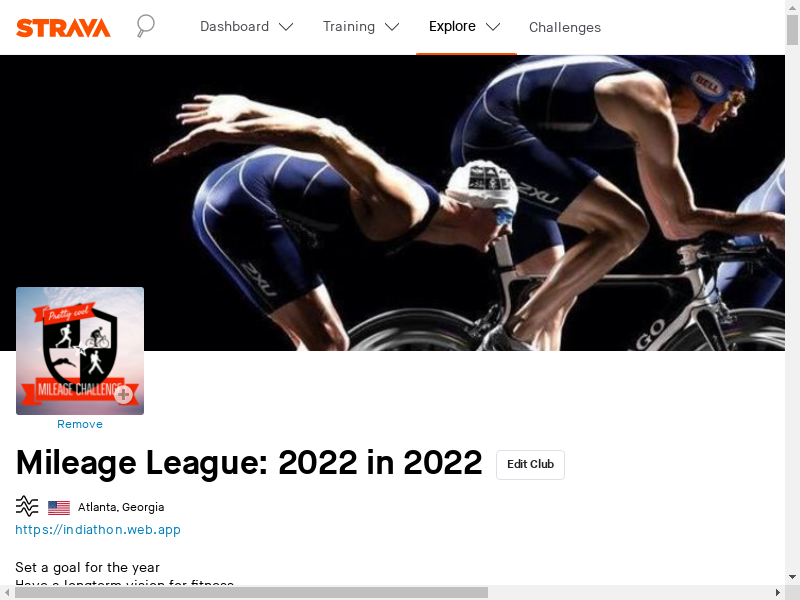

In [24]:
# b.execute_script("window.scrollTo(0,0)")
Image(b.screenshot.png())

In [25]:
"get all attributes"
# for x in dir(b):
#   print(x,type(getattr(b,x)),)

'get all attributes'

# New section
